In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import keras.metrics as metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [235]:
data = pd.read_csv('dataset.csv') 

In [237]:
#get ind of blank WDIR
wdir_idx = data.query('WDIR == "-"').index

In [239]:
#replace blank WDIR with a surrounding WDIR
for w in wdir_idx:
    choices = data.iloc[w - 2: w + 3]['WDIR'].values #.mode())
    choice = np.random.choice(choices)
    while choice == '-':
        choice = np.random.choice(choices)
    data.ix[w,'WDIR'] = str(choice) 

/Users/ericcriteser/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [240]:
#verify no blank WDIR
data.query('WDIR == "-"')   

,GSTkts,WDIR,WSPDkts,WVHTft,time_stamp


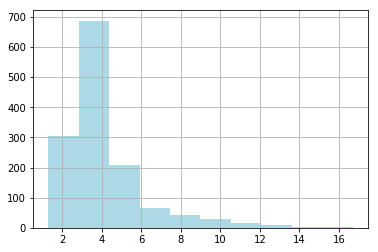

In [243]:
#plot wave height
data.WVHTft.hist(color = 'lightblue');

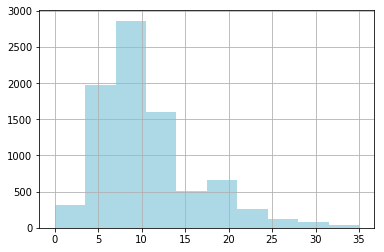

In [244]:
#plot wind speed
data.WSPDkts.hist(color = 'lightblue');

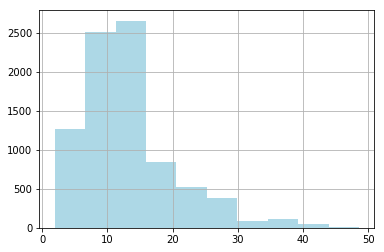

In [245]:
#plot gust
data.GSTkts.hist(color = 'lightblue');

In [247]:
#check df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8433 entries, 0 to 8432
Data columns (total 5 columns):
GSTkts        8433 non-null float64
WDIR          8433 non-null object
WSPDkts       8433 non-null float64
WVHTft        1370 non-null float64
time_stamp    8433 non-null object
dtypes: float64(3), object(2)
memory usage: 329.5+ KB


In [249]:
#WDIR to dummy
data = pd.get_dummies(data, columns=['WDIR'])

In [251]:
#available but doesnt help model ???
#scaler = MinMaxScaler(feature_range = (0,1))
#data[['WSPDkts', 'GSTkts', 'WVHTft']] = scaler.fit_transform(data[['WSPDkts', 'GSTkts', 'WVHTft']] )
#x_test = scaler.transform(x_test)

In [253]:
#get idx of wave height indications
nan_df = data.WVHTft > 0
t_df = data[nan_df]
idx = t_df.index.values

In [255]:
#returns range of idx
def get_idx(t_idx):
    idx_range = range(t_idx, t_idx + 14)
    return idx_range 

In [256]:
#gets usable random train/test idx for training
usable_idx = idx[:-2]
train_size = int(len(idx) * .8)
train_idx = np.random.choice(usable_idx, size = train_size, replace = False)
test_idx = []
for i in usable_idx:
    if i not in train_idx:
        test_idx.append(i)

In [257]:
#gets features and labels
def get_features_labels(rand_idx):
    features = []
    labels = []
    for r in rand_idx:
        t_idxs = get_idx(r) #gets range of idx
        range_df = data.iloc[t_idxs[0]: t_idxs[-1]] #range df
        label = range_df[:1]["WVHTft"].values[0] 
        feature = range_df.drop(['time_stamp', 'WVHTft'], axis = 1)
        feature.drop(t_idxs[0], inplace = True)
        features.append(np.array(feature))
        labels.append(np.array(label))
    return features, labels
x_train, y_train = get_features_labels(train_idx)
x_test, y_test = get_features_labels(test_idx)

In [258]:
#train array and reshape
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0], 1)
x_train.shape

(1096, 12, 18)

In [259]:
#test array and reshape
x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = y_test.reshape(y_test.shape[0], 1)
x_test.shape

(272, 12, 18)

In [261]:
#build model
model = Sequential()
model.add(LSTM(24, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(LSTM(24))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics = [metrics.mean_squared_error])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 12, 24)            4128      
_________________________________________________________________
lstm_10 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 8,857
Trainable params: 8,857
Non-trainable params: 0
_________________________________________________________________


In [263]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 10, min_lr = 0.0001, verbose = 1)
early_stop = EarlyStopping(monitor = 'loss', patience = 15)
checkpoint = ModelCheckpoint(filepath = 'base_model', monitor = 'val_loss', save_best_only = True, verbose = 1)

In [98]:
hist = model.fit(x_train, y_train, epochs= 30, batch_size=1, verbose=2, callbacks = [reduce_lr, early_stop, checkpoint], validation_split = .15)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 866 samples, validate on 153 samples
Epoch 1/30
 - 47s - loss: 0.9988 - mean_squared_error: 2.2373 - val_loss: 0.8838 - val_mean_squared_error: 1.4770

Epoch 00001: val_loss improved from inf to 0.88379, saving model to base_model
Epoch 2/30
 - 47s - loss: 0.9465 - mean_squared_error: 1.9012 - val_loss: 1.0665 - val_mean_squared_error: 2.5554

Epoch 00002: val_loss did not improve from 0.88379
Epoch 3/30
 - 56s - loss: 0.9272 - mean_squared_error: 1.7967 - val_loss: 0.9700 - val_mean_squared_error: 1.9223

Epoch 00003: val_loss did not improve from 0.88379
Epoch 4/30
 - 49s - loss: 0.8863 - mean_squared_error: 1.6126 - val_loss: 1.1271 - val_mean_squared_error: 2.1436

Epoch 00004: val_loss did not improve from 0.88379
Epoch 5/30
 - 56s - loss: 0.8530 - mean_squared_error: 1.4843 - val_loss: 0.8984 - val_mean_squared_error: 1.5912

Epoch 00005: val_loss did not improve from 0.88379


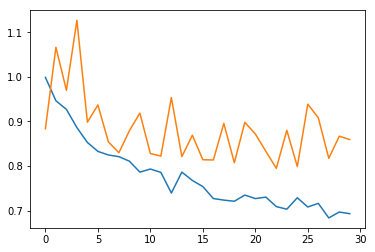

In [99]:
#plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss']);

In [264]:
model.load_weights('base_model')

In [265]:
preds = []
for i in range(0, len(x_test)):
    pred = model.predict(x_test[i:i+1])
    preds.append(pred[0][0])

In [266]:
#print metrics
mse = mean_squared_error(y_test, preds)
print('MSE: {}' format(mse))
print('RMSE: {}' .format(np.sqrt(mse)))

1.1112416189544867
RMSE: 1.05415445688


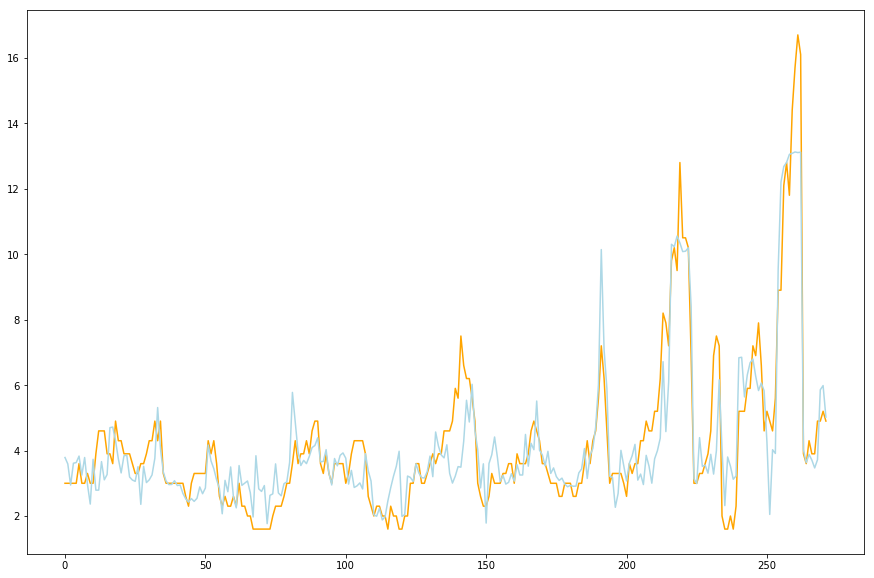

In [267]:
#plot predictions and actuals
plt.figure(figsize=(15,10))
plt.plot(y_test, color = 'orange');
plt.plot(preds, color = 'lightblue');